In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import datetime
import matplotlib.pyplot as plt
import numpy
from readSelfTrackerSheet import *

In [2]:
sheet = RetrieveSpreadSheet()

In [3]:
 SetUp(sheet)

Please indicate in semicolon seperated format who the desired trainees are.

	ie "Gamboa,Allan"; "Basior,Greg";...

	If all trainees are desired say:

	"all"

	Available Trainees are:

	Griffin
	Perkins
	Rowlett
	Warner
	Pittman
	Garvey
	Jestes
	Helwig
	Curnutt
	Frye
	Vaughan
all
Please provide the begin date in "M/D/YYYY" format (ie 5/11/1989) to filter
	"all"	if you dont want to filter:all


In [4]:
GetListOfTraineeObjects()

Creating Object For griffin

Creating Object For perkins

Creating Object For rowlett

Creating Object For warner

Creating Object For pittman

Creating Object For garvey

Creating Object For jestes

Creating Object For helwig

Creating Object For curnutt

Creating Object For frye

Creating Object For vaughan



In [5]:
FilterTraineesDateRanges()

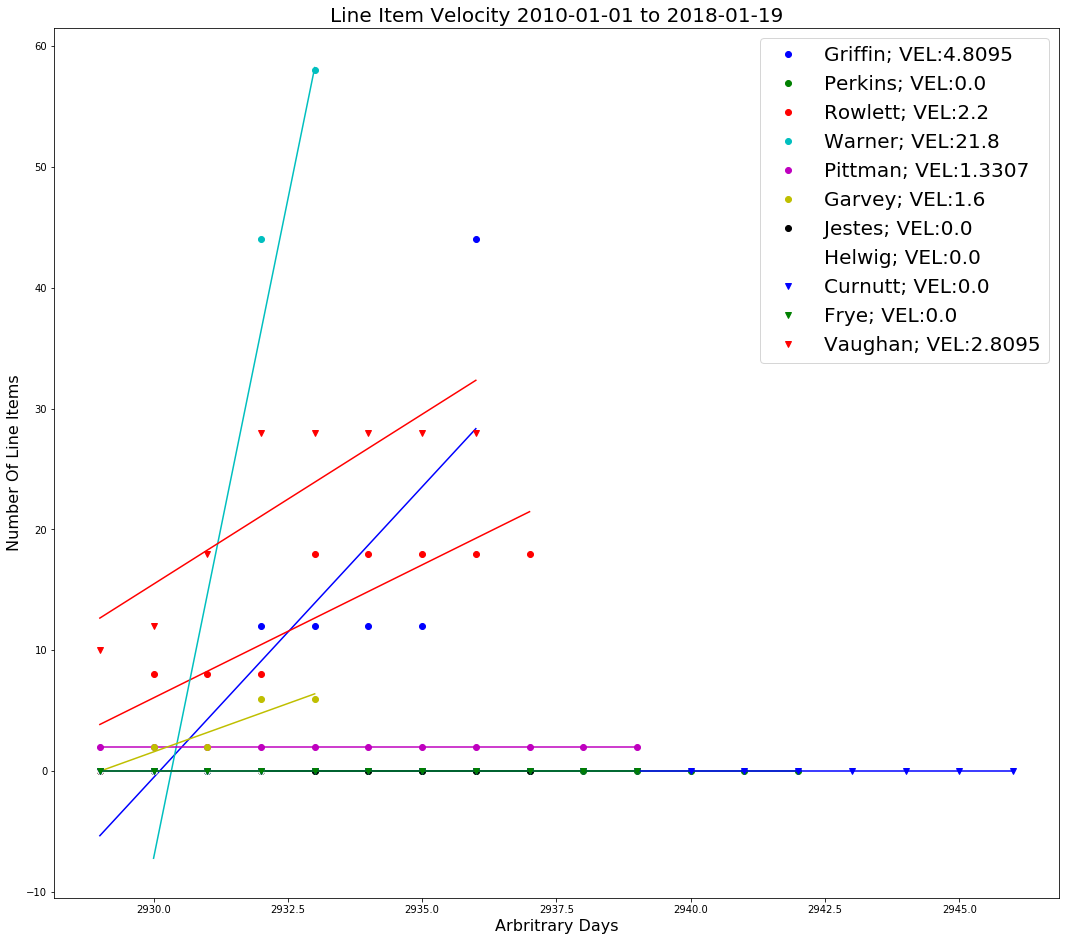

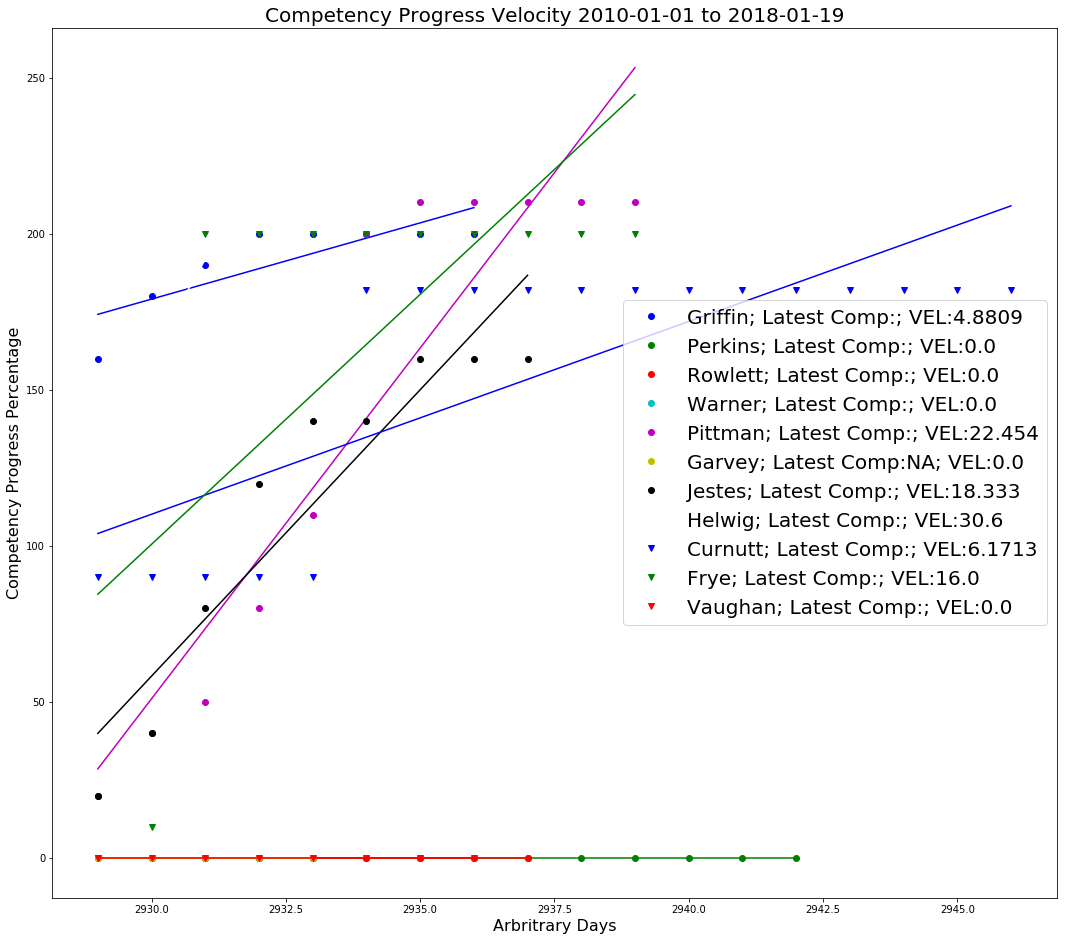

In [6]:
MakePlots()
   

In [7]:
CreateTableOfVelocities()


Line Velocity:	Mean = 3.020	STD = 6.130
Comp Velocity:	Mean = 8.949	STD = 10.504


         NAME          LINE ITEM VELOCITY  COMP PROGRESS VELOCITY LINE ITEMS COMPLETED   COMPS COMPLETED   
      Griffin               4.8095               4.8809                 22                   1          
      Perkins                0.0                  0.0                   0                    1          
      Rowlett                2.2                  0.0                   9                    0          
       Warner                21.8                 0.0                   29                   0          
      Pittman               1.3307               22.454                 1                    1          
       Garvey                1.6                  0.0                   3                    0          
       Jestes                0.0                 18.333                 0                    0          
       Helwig                0.0                  30.6                  0

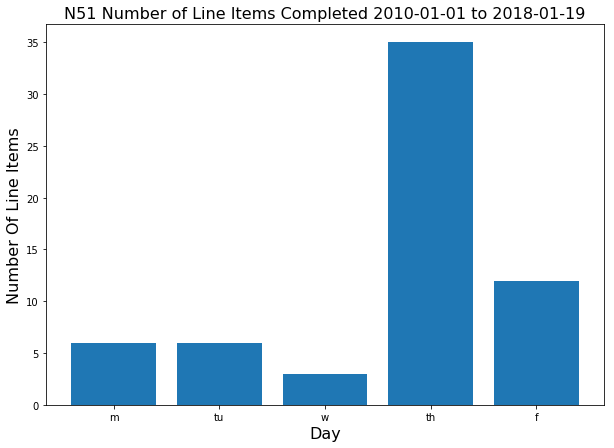

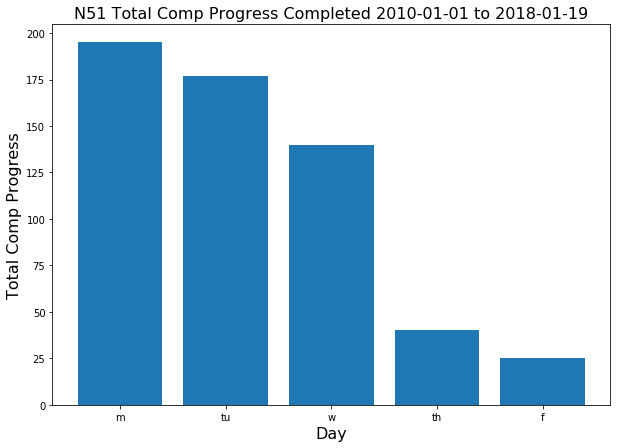

In [8]:
CreateDayOfWeekDistributions()

In [ ]:
UpdateJQRTracker()

In [28]:
class TraineeCounts:

    validCCompNames = ['C1', 'C2', 'C3', 'C4']
    ValidPyCompNames = ['Py1', 'Py2']
    ValidAsmCommpNames = ['Asm1', 'Asm2', 'Asm3']
    ValidCapNames = ['Cap']

    cComps = 'C Comps'
    pyComps = 'Python \nComps'
    asmComp = 'Assembly \nComps'
    capProj = 'Capstone \nProject'

    


    def __init__(self, Trainee, HistoricSheet=None):
        self.name = Trainee.name

        self.traineeComps = {TraineeCounts.cComps:0,
                         TraineeCounts.pyComps: 0,
                         TraineeCounts.asmComp: 0,
                         TraineeCounts.capProj: 0}

        self.historicalComps = {TraineeCounts.cComps:0,
                                TraineeCounts.pyComps: 0,
                                TraineeCounts.asmComp: 0,
                                TraineeCounts.capProj: 0}


        self.traineeSections = {'100':0,
                                '101':0,
                                '200':0,
                                '201':0,
                                '202':0,
                                #'203':0,
                                '204':0,
                                'Debug':0} #Same Row as 203

        self.historicSections = {'100':0,
                                '101':0,
                                '200':0,
                                '201':0,
                                '202':0,
                                #'203':0,
                                '204':0,
                                'Debug':0} #Same Row as 203
        
        self.historicCells = None
        self.targetCells = None
        
        
        for record in Trainee.records:
            if record.section != '' and record.section != None and record.section != ' ':
                self.traineeSections[record.section] = self.traineeSections[record.section]+record.numberOfLineItems
                if record.completedComp == 'y':
                    currComp = self.__CurrComp(record)
                    if currComp != 'err':
                        self.traineeComps[currComp] = self.traineeComps[currComp]+1

        if HistoricSheet != None:
            HistoricSheet = HistoricSheet.worksheets()[0]
            self.historicCells = HistoricSheet.get_all_values()
            self.UpdateHistoricCounts(HistoricSheet, self.historicSections)
            self.UpdateHistoricCounts(HistoricSheet, self.historicalComps)




    def __FindNameCell(self, sheet):

        try:
            return  sheet.find(self.name)
        except:
            print("%s not present in Historical Sheet.\n"%self.name)

        return None

    def UpdateHistoricCounts(self, sheet, dictionary):
        nameCellHistorical = TraineeCounts.findPositionOfCell(self.name, self.historicCells)
        
        if nameCellHistorical[0] == -1:
            print("Could not find %s in historical sheet.\n" % self.name)
            return

        tempCellKey = None
        tempCellVal = None

        for key in dictionary.keys():

            
            tempCellKey = TraineeCounts.findPositionOfCell(key, self.historicCells)
            
            if tempCellKey[0] == -1:
                print("%s not found in historic sheet.\n" % key)
                continue
            
            tempCellVal = sheet.cell(nameCellHistorical[0], tempCellKey[1])
            value = ''.join(c for c in tempCellVal.value if c.isalnum())
            #print("key: %s\tvalue: %s"%(key,tempCellVal.value))
            if value == '' or value == None:
                value = '0'
                
            dictionary[key] = int(value)


            

    def UpdateAllHistoricCounts(self, sheet):
        UpdateHistoricCounts(sheet, self.historicSections)
        UpdateHistoricCounts(sheet, self.historicalComps)



    def UpdateJQRTracker(self, TargetSheet):

        TargetSheet = TargetSheet.worksheets()[0]
        self.targetCells = TargetSheet.get_all_values()
        
        nameCellTarget = TraineeCounts.findPositionOfCell(self.name, self.targetCells)
        
        if nameCellTarget[0] == -1:
            print("Could not find %s in historical sheet.\n" % self.name)
            return
        
        tempCellKey = None
        for key in self.traineeSections.keys():
            
            tempCellKey = TraineeCounts.findPositionOfCell(key, self.targetCells)
            if tempCellKey[0] == -1:
                print("%s not found in target sheet.\n" % key)
                continue

            TargetSheet.update_cell(nameCellTarget[0], tempCellKey[1], self.traineeSections[key]+self.historicSections[key])
            
                

        for key in self.traineeComps.keys():

            tempCellKey = TraineeCounts.findPositionOfCell(key, self.targetCells)
            if tempCellKey[0] == -1:
                print("%s not found in target sheet.\n" % key)
                continue

            TargetSheet.update_cell(nameCellTarget[0], tempCellKey[1], self.traineeComps[key]+self.historicalComps[key])
                
    
    @staticmethod
    def findPositionOfCell(value, cells):
        row = 0
        col = 0
        for l in cells:
            col = 0
            for val in l:
                if ''.join(c for c in value if c.isalnum()) == ''.join(c for c in val if c.isalnum()):
                    return (row+1, col+1)
                col = col + 1
            row = row + 1

        return (-1,-1)


    def __CurrComp(self, record):
    
        if record.compentancy in TraineeCounts.validCCompNames:
            return TraineeCounts.cComps
        if record.compentancy in TraineeCounts.validCCompNames:
            return TraineeCounts.pyComps
        if record.compentancy in TraineeCounts.validCCompNames:
            return TraineeCounts.asmComp
        if record.compentancy in TraineeCounts.validCCompNames:
            return TraineeCounts.capProj

        print('%s is an invalid comp name.\n'%record.compentancy)
        return 'err'   

In [15]:
def UpdateJQRTracker(selfTrackerSheetName = 'JQR Self Progress', 
                     historicalTrackerSheetName = 'Historical Training Tracker', 
                     targetSheetName = 'Training Tracker'):
    
   
    selfTrackersheet = RetrieveSpreadSheet(spreadSheetName = selfTrackerSheetName)
    workSheets = selfTrackersheet.worksheets()

    #All trainees currently loaded
    allLoadedTrainees = [trainee.name.lower() for trainee in Trainees]

    for currWorkSheet in workSheets:
        # todo check that trainee is in list
        if currWorkSheet._title.lower() not in allLoadedTrainees and currWorkSheet._title.lower() not in ['blank', 'example']:
            print("Creating Object For in %s\n" % currWorkSheet._title.lower())
            currTrainee = Trainee(currWorkSheet)
            Trainees.append(currTrainee)

            
    
    historicalTrackerSheet = RetrieveSpreadSheet(spreadSheetName = historicalTrackerSheetName)
    
    targetSheet = RetrieveSpreadSheet(spreadSheetName = targetSheetName)
    
    for trainee in Trainees:
        tempCounts = TraineeCounts(trainee, historicalTrackerSheet)
        tempCounts.UpdateJQRTracker(targetSheet)

In [10]:
selfTrackerSheetName = 'JQR Self Progress' 
historicalTrackerSheetName = 'Historical Training Tracker'
targetSheetName = 'Target Training Tracker'

In [11]:

selfTrackersheet = RetrieveSpreadSheet(spreadSheetName = selfTrackerSheetName)
workSheets = selfTrackersheet.worksheets()

#All trainees currently loaded
allLoadedTrainees = [trainee.name.lower() for trainee in Trainees]

for currWorkSheet in workSheets:
    # todo check that trainee is in list
    if currWorkSheet._title.lower() not in allLoadedTrainees and currWorkSheet._title.lower() not in ['blank', 'example']:
        print("Creating Object For in %s\n" % currWorkSheet._title.lower())
        currTrainee = Trainee(currWorkSheet)
        Trainees.append(currTrainee)


In [12]:
historicalTrackerSheet = RetrieveSpreadSheet(spreadSheetName = historicalTrackerSheetName)
    
targetSheet = RetrieveSpreadSheet(spreadSheetName = targetSheetName)

In [29]:
tempCounts = TraineeCounts(Trainees[4], historicalTrackerSheet)

In [30]:
tempCounts.UpdateJQRTracker(targetSheet)

In [17]:
targetSheet.worksheets()

[<Worksheet 'sheet1' id:o23bsyf>]